<a href="https://colab.research.google.com/github/areias/viral-escape/blob/main/original_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# look at embeddings from original model


In [1]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# clone repository
! git clone https://github.com/brianhie/viral-mutation.git

Cloning into 'viral-mutation'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1106 (delta 131), reused 117 (delta 66), pack-reused 890
Receiving objects: 100% (1106/1106), 177.41 MiB | 34.33 MiB/s, done.
Resolving deltas: 100% (739/739), done.
Checking out files: 100% (84/84), done.


In [3]:
# add mutation to path
import sys
sys.path.append('viral-mutation/bin')



In [4]:
# arg
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name',
                                     'dim','n_epochs','batch_size',
                                     'namespace','seed','checkpoint'])

args = arguments('bilstm',512,3,350, # defaults were batch-size 1000, 14 epochs
                 'flu',1, "drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5")
args


arguments(model_name='bilstm', dim=512, n_epochs=3, batch_size=350, namespace='flu', seed=1, checkpoint='drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5')

In [5]:
# vocabulary
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
    
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }

In [6]:
# seqs

# download data
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz


--2022-02-06 13:01:25--  http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
Resolving cb.csail.mit.edu (cb.csail.mit.edu)... 128.30.2.148
Connecting to cb.csail.mit.edu (cb.csail.mit.edu)|128.30.2.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060938794 (2.9G) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.85G  63.7MB/s    in 29s     

2022-02-06 13:01:55 (99.2 MB/s) - ‘data.tar.gz’ saved [3060938794/3060938794]



In [7]:
# unzip data
!tar xvf data.tar.gz

data/
data/escape_results.txt
data/evcouplings/
data/evcouplings/flu_h3_config.yaml
data/evcouplings/flu_h1_config.yaml
data/evcouplings/hiv_bf520_seq.fa
data/evcouplings/hiv_env_seq.fa
data/evcouplings/hiv_env_config.yaml
data/evcouplings/sarscov2_config.yaml
data/evcouplings/flu_h1_seq.fa
data/evcouplings/hiv_bf520_config.yaml
data/evcouplings/sarscov2_seq.fa
data/evcouplings/flu_h3_seq.fa
data/headlines/
data/headlines/abcnews-date-text.csv
data/headlines/headlines.txt
data/hiv/
data/hiv/bg505_regions.txt
data/hiv/fitness_haddox2018/
data/hiv/fitness_haddox2018/BG505-1_prefs.csv
data/hiv/fitness_haddox2018/BG505-3_prefs.csv
data/hiv/fitness_haddox2018/BG505-2_prefs.csv
data/hiv/fitness_haddox2018/BF520-3_prefs.csv
data/hiv/fitness_haddox2018/BF520-2_prefs.csv
data/hiv/fitness_haddox2018/BF520-1_prefs.csv
data/hiv/fitness_haddox2018/BF520_to_HXB2.csv
data/hiv/fitness_haddox2018/BF520_env.fasta
data/hiv/fitness_haddox2018/map_indices.py
data/hiv/fitness_haddox2018/BF520_avgprefs.csv
d

In [8]:
! pip install scanpy

     |████████████████████████████████| 2.0 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 91 kB 9.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=0280da079144bc6165dbb7a2af2f90494864d817c170bc4b6873a8a68eeb7dde
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=cefd2f180cf67ed4e90df52c79a61466797bedcc813ff8a7db8f2fb878be9ede
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=c9fb973faa294bdc683ca64044996dad9637174d6018d35090053ded78e91baa
  Stored in directory: /root/.cache/pi

In [9]:
! pip install anndata

In [10]:
! pip install bio

     |████████████████████████████████| 271 kB 5.0 MB/s 
     |████████████████████████████████| 2.3 MB 42.8 MB/s 


In [11]:
from mutation import *

In [12]:
def setup(args):
    fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies.fa' ]
    meta_fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies_meta.tsv' ]

    seqs = process(fnames, meta_fnames)

    seq_len = max([ len(seq) for seq in seqs ]) + 2
    vocab_size = len(AAs) + 2

    model = get_model(args, seq_len, vocab_size)

    return model, seqs


In [13]:
def process(fnames, meta_fnames):
    metas = load_meta(meta_fnames)

    seqs = {}
    for fname in fnames:
        for record in SeqIO.parse(fname, 'fasta'):
            if 'Reference_Perth2009_HA_coding_sequence' in record.description:
                continue
            if str(record.seq).count('X') > 10:
                continue
            if record.seq not in seqs:
                seqs[record.seq] = []
            accession = record.description.split('|')[0].split(':')[1]
            seqs[record.seq].append(metas[accession])
    return seqs



In [14]:
def load_meta(meta_fnames):
    metas = {}
    for fname in meta_fnames:
        with open(fname) as f:
            header = f.readline().rstrip().split('\t')
            for line in f:
                fields = line.rstrip().split('\t')
                accession = fields[1]
                meta = {}
                for key, value in zip(header, fields):
                    if key == 'Subtype':
                        meta[key] = value.strip('()').split('N')[0].split('/')[-1]
                    elif key == 'Collection Date':
                        meta[key] = int(value.split('/')[-1]) \
                                    if value != '-N/A-' else None
                    elif key == 'Host Species':
                        meta[key] = value.split(':')[1].split('/')[-1].lower()
                    else:
                        meta[key] = value
                metas[accession] = meta
    return metas



In [15]:
model, seqs = setup(args)

In [93]:
from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:10]:
    seqs_subset[x] = seqs[x]



In [94]:
len(seqs_subset)

10

In [95]:
model.model_.load_weights(args.checkpoint)
tprint('Model summary:')
tprint(model.model_.summary())



2022-02-06 13:44:54.714071 | Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 577)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 577)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 577, 20)      580         ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 577, 512)  

In [96]:
#analyze_embedding(args, model, seqs, vocabulary)

In [97]:
def analyze_embedding(args, model, seqs, vocabulary):
    seqs = embed_seqs(args, model, seqs, vocabulary, use_cache=True)

    X, obs = [], {}
    obs['n_seq'] = []
    obs['seq'] = []
    for seq in seqs:
        meta = seqs[seq][0]
        X.append(meta['embedding'].mean(0))
        for key in meta:
            if key == 'embedding':
                continue
            if key not in obs:
                obs[key] = []
            obs[key].append(Counter([
                meta[key] for meta in seqs[seq]
            ]).most_common(1)[0][0])
        obs['n_seq'].append(len(seqs[seq]))
        obs['seq'].append(str(seq))
    X = np.array(X)

    adata = AnnData(X)
    for key in obs:
        adata.obs[key] = obs[key]
    adata = adata[
        np.logical_or.reduce((
            adata.obs['Host Species'] == 'human',
            adata.obs['Host Species'] == 'avian',
            adata.obs['Host Species'] == 'swine',
        ))
    ]

    sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
    sc.tl.louvain(adata, resolution=1.)

    sc.set_figure_params(dpi_save=500)

    sc.tl.umap(adata, min_dist=1.)
    plot_umap(adata)
    plot_umap(adata[adata.obs['louvain'] == '30'],
              namespace='flu1918')

    interpret_clusters(adata)

    seq_clusters(adata)

In [98]:
# https://github.com/brianhie/viral-mutation/blob/master/bin/mutation.py
def embed_seqs(args, model, seqs, vocabulary,
               use_cache=False, verbose=True, namespace=None):
    if namespace is None:
        namespace = args.namespace

    if 'esm' in args.model_name:
        from fb_semantics import embed_seqs_fb
        seqs_fb = [ seq for seq in seqs ]
        return embed_seqs_fb(
            model.model_, seqs_fb, model.repr_layers_, model.alphabet_,
            use_cache=use_cache, verbose=verbose,
        )

    X_cat, lengths = featurize_seqs(seqs, vocabulary)

    if use_cache:
        mkdir_p('target/{}/embedding'.format(namespace))
        embed_fname = ('target/{}/embedding/{}_{}.npy'
                       .format(namespace, args.model_name, args.dim))
    else:
        embed_fname = None

    if use_cache and os.path.exists(embed_fname):
        X_embed = np.load(embed_fname, allow_pickle=True)
    else:
        model.verbose_ = verbose
        X_embed = model.transform(X_cat, lengths, embed_fname)
        if use_cache:
            np.save(embed_fname, X_embed)

    sorted_seqs = sorted(seqs)
    for seq_idx, seq in enumerate(sorted_seqs):
        for meta in seqs[seq]:
            meta['embedding'] = X_embed[seq_idx]

    return seqs

In [99]:
#def featurize_seqs(seqs, vocabulary):
start_int = len(vocabulary) + 1
end_int = len(vocabulary) + 2


In [100]:
start_int


26

In [101]:
end_int

27

In [102]:
sorted_seqs = sorted(seqs_subset.keys())

In [103]:
len(sorted_seqs[:1])

1

In [104]:
# they add a 26 before every amino acid, a 27 at the end and then concatenate it all together, all sequences 
start_int = len(vocabulary) + 1
end_int = len(vocabulary) + 2
sorted_seqs = sorted(seqs_subset.keys())
X = np.concatenate([
    np.array([ start_int ] + [
        vocabulary[word] for word in seq 
    ] + [ end_int ]) for seq in sorted_seqs]).reshape(-1, 1)
lens = np.array([ len(seq) + 2 for seq in sorted_seqs ])
assert(sum(lens) == X.shape[0])
#return X, lens

In [105]:
 np.concatenate([np.array([ start_int ] + [vocabulary[word] for word in seq ] + [ end_int ]) for seq in sorted_seqs[0] ] ).reshape(-1, 1)

array([[26],
       [13],
       [27],
       ...,
       [26],
       [ 9],
       [27]])

In [106]:
#564
X.shape


(5673, 1)

In [107]:
567+568+562

1697

In [108]:
lens

array([568, 568, 568, 568, 568, 568, 567, 568, 568, 562])

In [109]:
namespace = args.namespace
#if use_cache:
mkdir_p('target/{}/embedding'.format(namespace))
embed_fname = ('target/{}/embedding/{}_{}.npy'
                .format(namespace, args.model_name, args.dim))

In [110]:
embed_fname

'target/flu/embedding/bilstm_512.npy'

In [111]:
# ctrl+/ to comment all lines

# model.verbose_ = verbose
# X_embed = model.transform(X_cat, lengths, embed_fname)
# if use_cache:
#     np.save(embed_fname, X_embed)


In [112]:
   def transform(self, X_cat, lengths, embed_fname=None):
        X = self.split_and_pad(
            X_cat, lengths,
            self.seq_len_, self.vocab_size_, self.verbose_,
        )[0]

        # For now, each character in each sequence becomes a sample.
        n_samples = sum(lengths)
        if type(X) == list:
            for X_i in X:
                assert(X_i.shape[0] == n_samples)
        else:
            assert(X.shape[0] == n_samples)

        # Embed using the output of a hidden layer.
        hidden = tf.keras.backend.function(
            inputs=self.model_.input,
            outputs=self.model_.get_layer('embed_layer').output,
        )

        # Manage batching to avoid overwhelming GPU memory.
        X_embed_cat = []
        n_batches = math.ceil(n_samples / self.inference_batch_size_)
        if self.verbose_:
            tprint('Embedding...')
            prog_bar = tf.keras.utils.Progbar(n_batches)
        for batchi in range(n_batches):
            start = batchi * self.inference_batch_size_
            end = min((batchi + 1) * self.inference_batch_size_, n_samples)
            if type(X) == list:
                X_batch = [ X_i[start:end] for X_i in X ]
            else:
                X_batch = X[start:end]
            X_embed_cat.append(hidden(X_batch))
            if self.verbose_:
                prog_bar.add(1)
        X_embed_cat = np.concatenate(X_embed_cat)
        if self.verbose_:
            tprint('Done embedding.')

        X_embed = np.array([
            X_embed_cat[start:end]
            for start, end in
            iterate_lengths(lengths, self.seq_len_)
        ])

        return X_embed

In [113]:
n_batches = math.ceil(1697 / 1500)
n_batches

2

In [116]:
# two batches because we have batch size 1500 and 1697 samples
X_embed = model.transform(X, lens, embed_fname)

2022-02-06 13:45:15.172363 | Embedding...
4/4 [==============================] - 1164s 293s/step
2022-02-06 14:04:39.290011 | Done embedding.


viral-mutation/bin/language_model.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  iterate_lengths(lengths, self.seq_len_)


In [118]:
model.inference_batch_size_

1500

In [119]:
X_embed.shape

(10,)

In [120]:
# shape of signle sequence embedding
# 562 rows (number of tokens), 1024 columns
X_embed[2].shape

(568, 1024)

In [121]:
# saves embeddings 
np.save(embed_fname, X_embed)

In [122]:
# add embedding to sequence dictionary
sorted_seqs = sorted(seqs_subset)
for seq_idx, seq in enumerate(sorted_seqs):
    for meta in seqs_subset[seq]:
        meta['embedding'] = X_embed[seq_idx]

In [123]:
seqs_subset

defaultdict(dict,
            {Seq('MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKH...ICI'): [{'Collection Date': 2009,
               'Complete Genome': 'Yes',
               'Country': 'Denmark',
               'Flu Season': '09-10',
               'Host Species': 'human',
               'Name': 'HA',
               'Segment': '4',
               'Segment Length': '1734',
               'Sequence Accession': 'CY062691',
               'State/Province': '-N/A-',
               'Strain Name': 'A/Aarhus/INS116/2009(H1N1)',
               'Subtype': 'H1',
               'embedding': array([[-4.0876325e-03,  4.7387434e-03,  3.0577895e-01, ...,
                        9.4303489e-04,  6.4578652e-03,  3.8205275e-01],
                      [-4.7921322e-04,  9.3112969e-01,  2.4222764e-03, ...,
                        2.6112199e-03,  4.2520672e-01,  1.4828961e-02],
                      [-6.6961989e-02,  2.5158213e-03,  2.0701651e-04, ...,
                        3.4280211e-01,  9.806884

In [124]:
# for each token they take the average of the embedding across the 1024 columns
# axis=0 is columns
X=[]
for seq in seqs_subset:
    meta = seqs_subset[seq][0]
    X.append(meta['embedding'].mean(0))

In [125]:
len(X)

10

In [126]:
[len(i) for i in X]

[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]

In [127]:
X, obs = [], {}
obs['n_seq'] = []
obs['seq'] = []
for seq in seqs_subset:
    meta = seqs_subset[seq][0]
    X.append(meta['embedding'].mean(0))
    for key in meta:
        if key == 'embedding':
            continue
        if key not in obs:
            obs[key] = []
        obs[key].append(Counter([
            meta[key] for meta in seqs_subset[seq]
        ]).most_common(1)[0][0])
    obs['n_seq'].append(len(seqs_subset[seq]))
    obs['seq'].append(str(seq))
X = np.array(X)

In [128]:
X

array([[-0.21952093,  0.15302822,  0.08027752, ...,  0.15850776,
         0.4371412 ,  0.24013731],
       [-0.2164791 ,  0.15193553,  0.08483234, ...,  0.14954166,
         0.44265613,  0.22463955],
       [-0.21291347,  0.15359351,  0.07886145, ...,  0.14754881,
         0.42821074,  0.2195413 ],
       ...,
       [-0.21594924,  0.16822106,  0.08096878, ...,  0.14493552,
         0.42749903,  0.21608695],
       [-0.21860074,  0.17017515,  0.08029153, ...,  0.14730766,
         0.43352154,  0.22245294],
       [-0.21654777,  0.17245442,  0.08796009, ...,  0.1459092 ,
         0.42995238,  0.21446306]], dtype=float32)

In [129]:
obs

{'Collection Date': [1980,
  1933,
  1945,
  1943,
  2009,
  2009,
  2009,
  2009,
  2009,
  2009],
 'Complete Genome': ['No',
  'Yes',
  'Yes',
  'Yes',
  'Yes',
  'Yes',
  'No',
  'Yes',
  'Yes',
  'Yes'],
 'Country': ['USA',
  'United Kingdom',
  'USA',
  'USA',
  'Denmark',
  'Denmark',
  'Finland',
  'Denmark',
  'Denmark',
  'Germany'],
 'Flu Season': ['-N/A-',
  '-N/A-',
  '-N/A-',
  '-N/A-',
  '09-10',
  '09-10',
  '09-10',
  '09-10',
  '09-10',
  '09-10'],
 'Host Species': ['sea mammal',
  'human',
  'human',
  'human',
  'human',
  'human',
  'human',
  'human',
  'human',
  'human'],
 'Name': ['HA', 'HA', 'HA', 'HA', 'HA', 'HA', 'HA', 'HA', 'HA', 'HA'],
 'Segment': ['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'],
 'Segment Length': ['1730',
  '1775',
  '1751',
  '1741',
  '1734',
  '1734',
  '1701',
  '1734',
  '1734',
  '1734'],
 'Sequence Accession': ['K00429',
  'J02176',
  'CY021709',
  'CY020285',
  'CY083910',
  'CY063606',
  'CY083776',
  'CY073725',
  'CY062691',


In [130]:
 adata = AnnData(X)
for key in obs:
    adata.obs[key] = obs[key]
adata = adata[
    np.logical_or.reduce((
        adata.obs['Host Species'] == 'human',
        adata.obs['Host Species'] == 'avian',
        adata.obs['Host Species'] == 'swine',
    ))
]

In [131]:
adata

View of AnnData object with n_obs × n_vars = 9 × 1024
    obs: 'n_seq', 'seq', 'Name', 'Sequence Accession', 'Complete Genome', 'Segment', 'Segment Length', 'Subtype', 'Collection Date', 'Host Species', 'Country', 'State/Province', 'Flu Season', 'Strain Name'

In [132]:
# sc is scanpy
# https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html
# Compute a neighborhood graph of observations [McInnes18].
sc.pp.neighbors(adata, n_neighbors=2, use_rep='X')

In [89]:
! pip install igraph

In [90]:
! pip install louvain

In [133]:
#Cluster cells using the Louvain algorithm [Blondel08] in the implementation of [Traag17]. The Louvain algorithm has been proposed for single-cell analysis
sc.tl.louvain(adata, resolution=1.)

In [136]:
! pip install umap-learn[plot]

     |████████████████████████████████| 15.8 MB 2.1 kB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 830 kB 59.1 MB/s 
     |████████████████████████████████| 133 kB 61.9 MB/s 
     |████████████████████████████████| 822 kB 39.0 MB/s 
     |████████████████████████████████| 802 kB 65.9 MB/s 
     |████████████████████████████████| 802 kB 47.8 MB/s 
     |████████████████████████████████| 793 kB 54.2 MB/s 
     |████████████████████████████████| 793 kB 43.7 MB/s 
     |████████████████████████████████| 791 kB 56.9 MB/s 
     |████████████████████████████████| 786 kB 49.6 MB/s 
     |████████████████████████████████| 779 kB 44.7 MB/s 
     |████████████████████████████████| 778 kB 55.0 MB/s 
     |████████████████████████████████| 776 kB 38.4 MB/s 
     |████████████████████████████████| 769 kB 47.8 MB/s 
     |████████████████████████████████| 766 kB 39.2 MB/s 
     |████████████████████████████████| 1.0 MB 44.2 MB/s 
     |██████████

In [140]:
def plot_umap(adata, namespace='flu'):
    if namespace == 'flu1918':
        plt.figure()
        ax = plt.gca()
        sc.pl.umap(adata, color='Host Species', ax=ax, size=20)
        ratio = 0.3
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
        plt.savefig('figures/umap_{}_species.png'.format(namespace))
        plt.close()
    else:
        sc.pl.umap(adata, color='Host Species',
                   save='_{}_species.png'.format(namespace))

    sc.pl.umap(adata, color='Subtype',
               save='_{}_subtype.png'.format(namespace))
    sc.pl.umap(adata, color='Collection Date',
               save='_{}_date.png'.format(namespace))
    sc.pl.umap(adata, color='louvain',
               save='_{}_louvain.png'.format(namespace))

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Name' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Complete Genome' as categorical
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new C

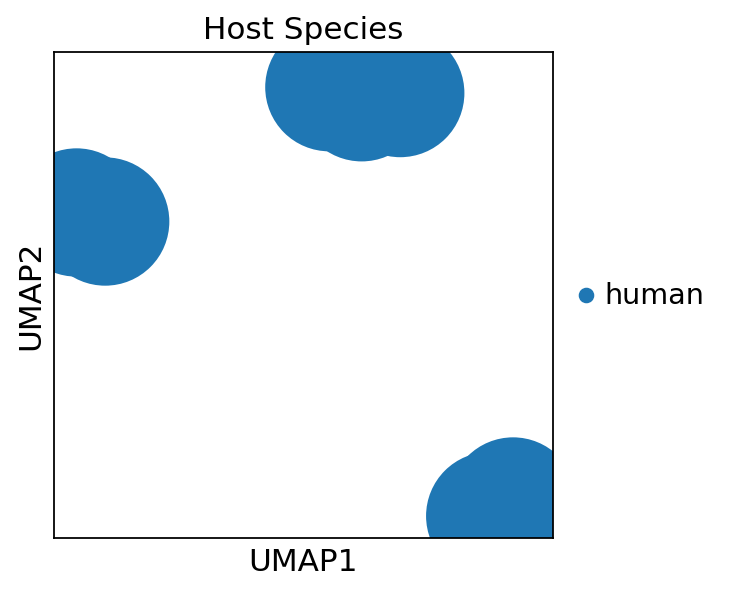

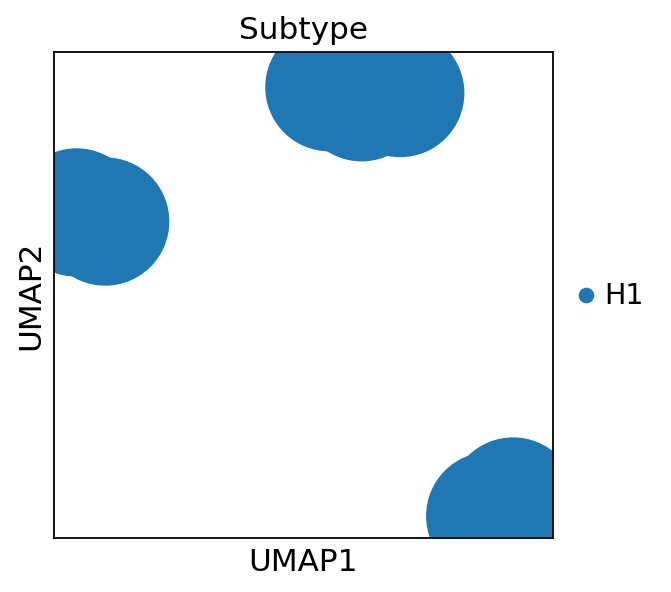

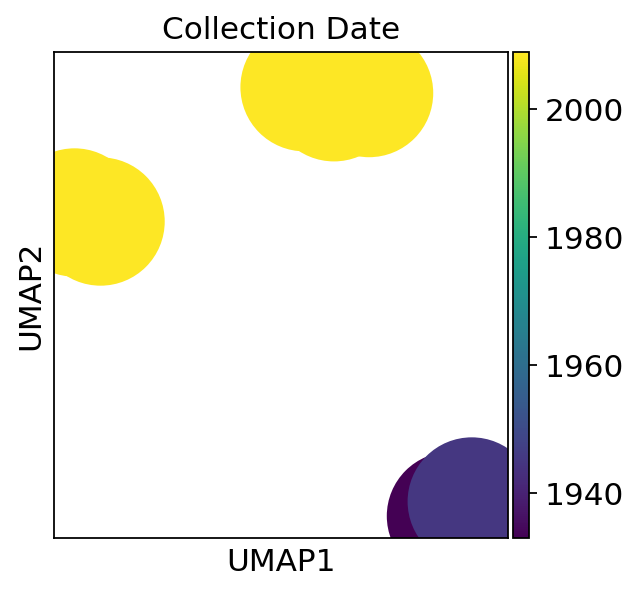

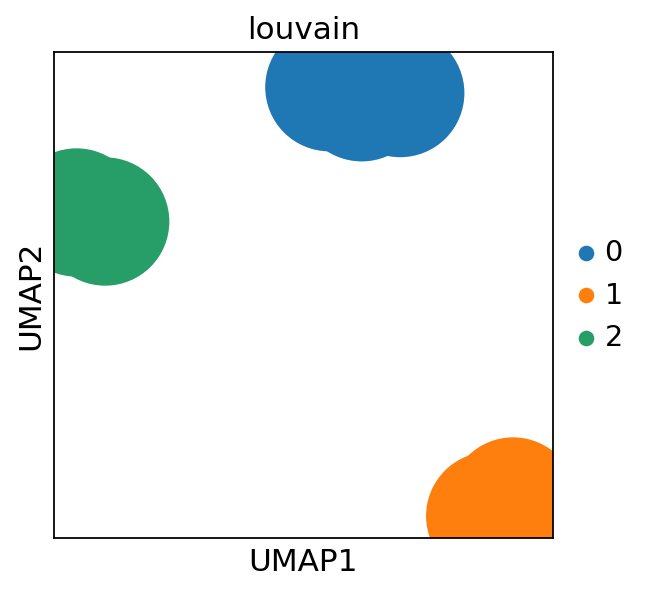

In [141]:
import umap
import umap.plot
sc.set_figure_params(dpi_save=500)

sc.tl.umap(adata, min_dist=1.)
plot_umap(adata)